In [2]:
%load_ext autoreload
%autoreload 2

import os 
import shutil
import numpy as n
from datetime import date
from matplotlib import pyplot as plt
import time
import napari

In [3]:
os.chdir('/home/ali/packages/s2p-lbm/')

from suite3d.job import Job
from suite3d import lbmio, utils, ui
from suite3d import tiff_utils as tfu
from suite3d import file_utils as flu

In [4]:
job_params = {    
    'notch_filt' :     None,
    'n_ch_tif' : 26,
    'convert_plane_ids_to_channel_ids' : False,
    
    'n_init_files' :   1,
    'init_file_pool' : None,
    'init_file_sample_method': 'random',
    
    'subtract_crosstalk' : True,
    'override_crosstalk' : 0.36,
    'crosstalk_n_planes' : 4, 
    
    'nonrigid' : True,
    'smooth_sigma' : 1.15,
    'maxregshift' : 0.15,
    'reg_filter_pcorr' : 1,
    'generate_sample_registered_bins' : False,

    'dtype' : n.float32,
    'tif_batch_size' : 1,
}



In [5]:
subjects_dir =   '/mnt/zortex-subjects/'
expt_info = { 
    'subject':         'AH012',
    'date' :          '2024-06-12',
    'expnum' :         [1,2,3,4,5,6,7,9,10,11,12,13,14,16,17,18],}

tifs, si_params, exp_str = flu.find_exp(subjects_dir, **expt_info, verbose=False)

job_params['fs'] = si_params['vol_rate']

savedir = os.path.join('/mnt/md0/runs', expt_info['subject'], expt_info['date'])
os.makedirs(savedir, exist_ok=True)

# Create the job
job = Job('/mnt/md0/runs',exp_str, tifs = tifs,
          params=job_params, create=False, overwrite=True, verbosity = 100)



   Found and loaded params from /mnt/md0/runs/s3d-AH012_2024-06-12_1-2-3-4-5-6-7-9-10-11-12-13-14-16-17-18/params.npy


In [8]:
metric_files = job.get_registered_files(filename_filter='reg_metrics')

mean_images = job.get_registered_files(filename_filter='mean')

imgs = [n.load(img,mmap_mode = 'r') for img in mean_images]

(<Figure size 1200x900 with 1 Axes>,
 <Axes: >,
 <matplotlib.image.AxesImage at 0x7eff2fadd7f0>)

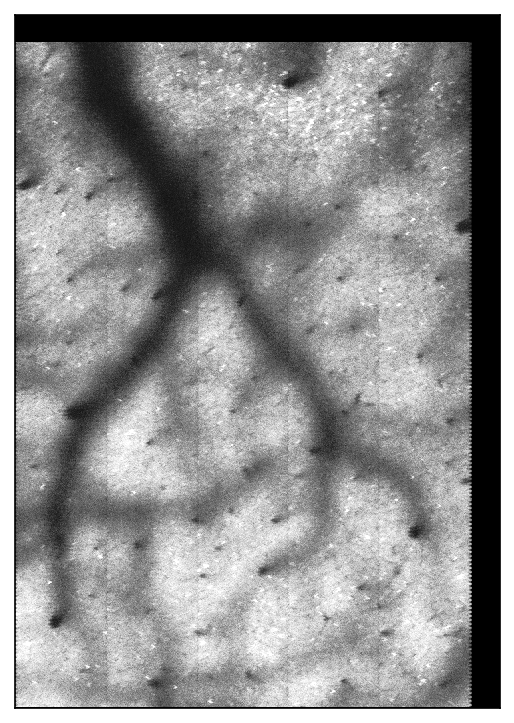

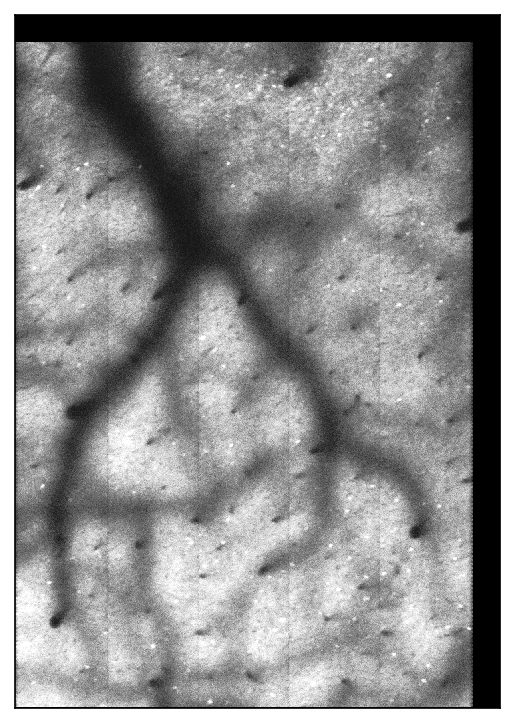

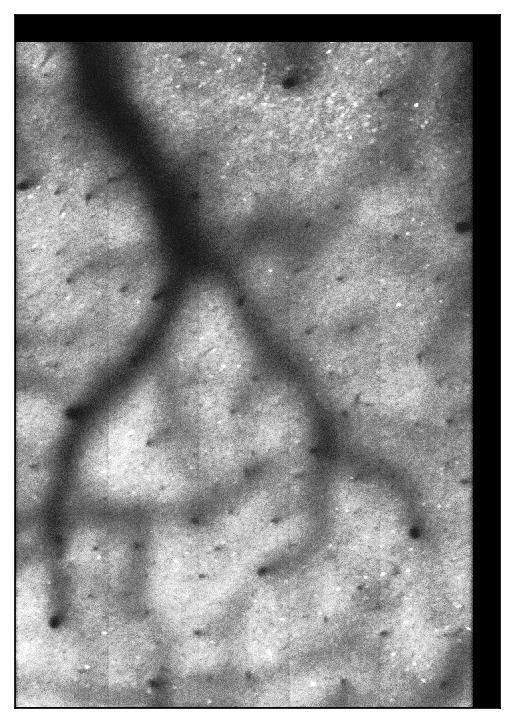

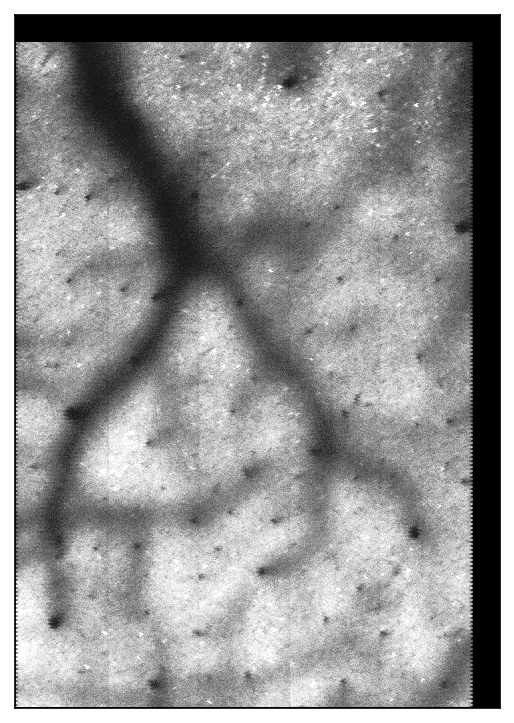

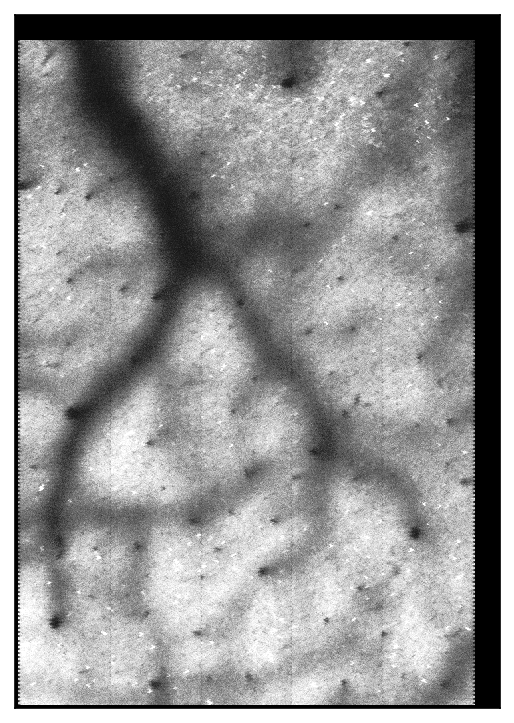

In [9]:
plane_idx = 10
tfu.show_tif(imgs[0][plane_idx], vminmax=(0,8000))
tfu.show_tif(imgs[50][plane_idx], vminmax=(0,8000))
tfu.show_tif(imgs[100][plane_idx], vminmax=(0,8000))
tfu.show_tif(imgs[150][plane_idx], vminmax=(0,8000))
tfu.show_tif(imgs[350][plane_idx], vminmax=(0,8000))

In [69]:
res = job.load_registration_results()

res['pc_peak_loc'] = n.concatenate(res['pc_peak_loc'],axis=0)
res['int_shift'] = n.concatenate(res['int_shift'],axis=0) * job.params['voxel_size_um']
res['sub_pixel_shifts'] = n.concatenate(res['sub_pixel_shifts'],axis=0) * job.params['voxel_size_um']
phase_corr_max = n.concatenate([pcorr.max(axis=(1,2,3)) for pcorr in res['phase_corr_shifted']])

In [70]:
phase_corr_max.shape

(34805,)

In [68]:
res['phase_corr_shifted'][0].shape

(100, 5, 81, 81)

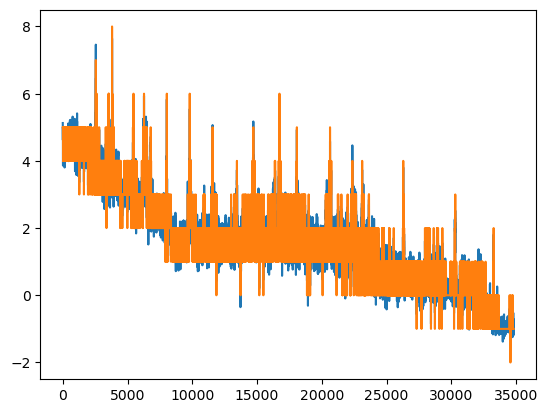

In [38]:
plt.plot(res['sub_pixel_shifts'][:,2])
plt.plot(res['int_shift'][:,2])

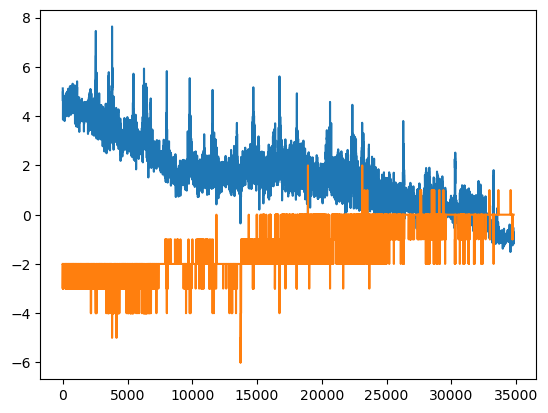

In [37]:
plt.plot(res['sub_pixel_shifts'][:,2])
plt.plot(res['sub_pixel_shifts'][:,1])

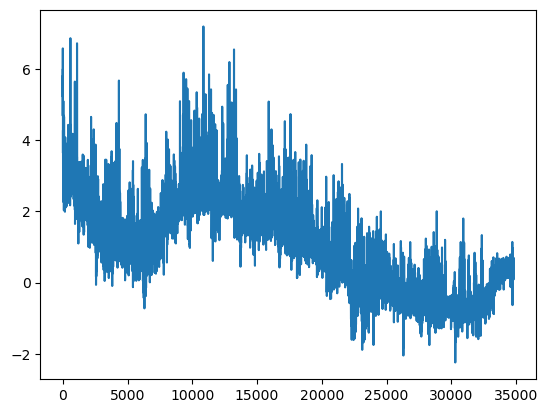

In [65]:
plt.plot(res['sub_pixel_shifts'][:,0])

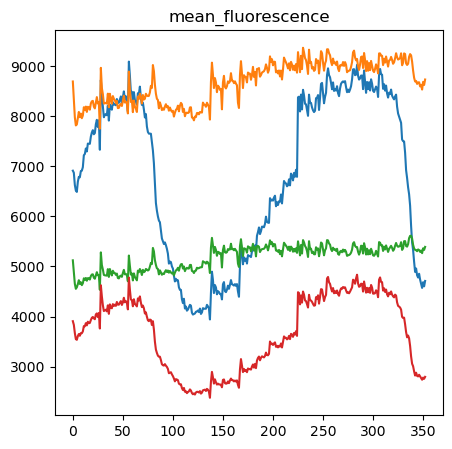

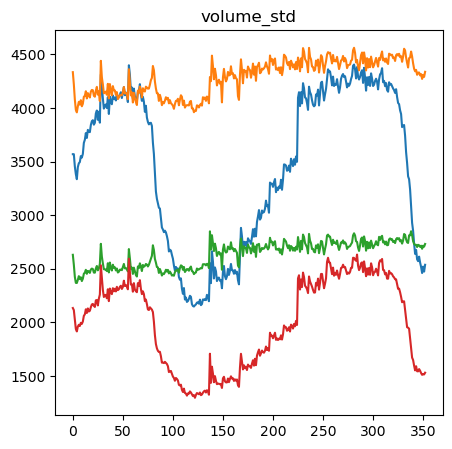

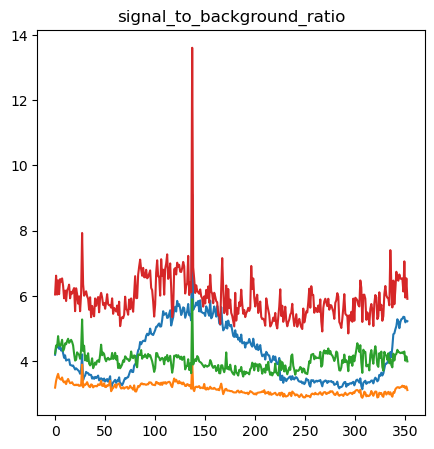

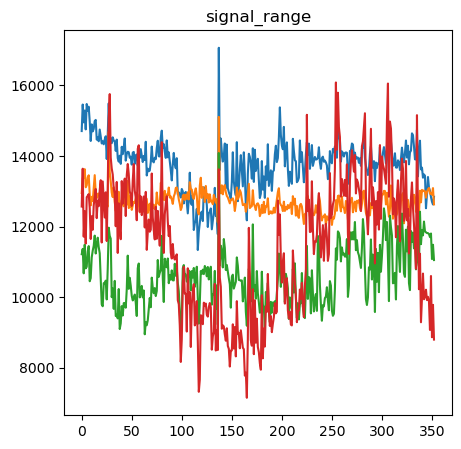

In [10]:
quality_dict = n.load(metric_files[0],allow_pickle=True).item()
for k in quality_dict.keys():
    quality_dict[k] = quality_dict[k][n.newaxis]

for i in range(1,len(metric_files)):
    new_data = n.load(metric_files[i],allow_pickle=True).item()
    for k in quality_dict.keys():
        quality_dict[k] = n.concatenate([quality_dict[k], new_data[k][n.newaxis]],axis=0)

metrics = ['mean_fluorescence','volume_std', 'signal_to_background_ratio', 'signal_range']
planes = [0, 4, 8, 12]

for i,metric in enumerate(metrics):
    f = plt.figure(figsize=(5,5))
    for plane in planes:
        plt.plot(quality_dict[metric][:,plane])
    plt.title(metric)